<a href="https://colab.research.google.com/github/Pouyaaskari/Image-Segmentation/blob/master/Polyp_segmentation_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1-Importing dataset from Kaggle.com



In [25]:
!pip install -q kaggle
from google.colab import files
files.upload()
# upload the json file with kaggle.json name
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [26]:
!kaggle datasets download -d balraj98/cvcclinicdb

cvcclinicdb.zip: Skipping, found more recently modified local copy (use --force to force download)


In [27]:
!unzip /content/cvcclinicdb.zip

Archive:  /content/cvcclinicdb.zip
replace PNG/Ground Truth/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip /content/cvcclinicdb.zip

Archive:  /content/cvcclinicdb.zip
replace PNG/Ground Truth/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#2-Import necessary libraries

In [55]:
import os
from glob import glob
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import numpy as np
from tqdm import tqdm
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Concatenate,BatchNormalization,Activation,UpSampling2D,MaxPool2D,Input
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,CSVLogger,TensorBoard
from tensorflow.keras.metrics import Recall,Precision
from tensorflow.keras.utils import CustomObjectScope

#3-Preparing the dataset

In [56]:
def load_data(path,split=0.1):

  image=sorted(glob(os.path.join(path,"/content/PNG/Original/*")))
  Ground_truth=sorted(glob(os.path.join(path,"/content/PNG/Ground Truth/*")))

  total_size=len(image)
  valid_size=int(split*total_size)
  test_size=int(split*total_size)

  x_train,x_valid=train_test_split(image,test_size=valid_size,random_state=42)
  y_train,y_valid=train_test_split(Ground_truth,test_size=valid_size,random_state=42)

  x_train,x_test=train_test_split(x_train,test_size=valid_size,random_state=42)
  y_train,y_test=train_test_split(y_train,test_size=valid_size,random_state=42)

  return (x_train,y_train) , (x_valid,y_valid) , (x_test,y_test)

def read_image(path):

  path=path.decode()
  x=cv2.imread(path,cv2.IMREAD_COLOR)
  x=cv2.resize(x,(256,256))
  x=x/255.0

  return x

def read_Ground_truth(path):

  path=path.decode()
  x=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
  x=cv2.resize(x,(256,256))
  x=x/255.0
  x=np.expand_dims(x,axis=-1)

  return x

def tf_parse(x,y):
  def _parse(x,y):
    x=read_image(x)
    y=read_Ground_truth(y)

    return x,y
  
  x,y=tf.numpy_function(_parse,[x,y],[tf.float64,tf.float64])
  x.set_shape([256,256,3])
  y.set_shape([256,256,1])

  return x , y






def tf_dataset(x,y,batch=8):
  dataset=tf.data.Dataset.from_tensor_slices((x,y))
  dataset=dataset.map(tf_parse)
  dataset=dataset.batch(batch)
  dataset=dataset.repeat()

  return dataset




  print(total_size)
  print(valid_size)
  print(test_size)

if __name__=="__main__":
  np.random.seed(42)
  tf.random.set_seed(42)

  path="CVC"
  (x_train,y_train) , (x_valid,y_valid) , (x_test,y_test)=load_data(path)
  print(len(x_train),len(x_valid),len(x_test))


  ds=tf_dataset(x_test,y_test)

  for x , y in ds:
    print(x.shape,y.shape)
    break


490 61 61
(8, 256, 256, 3) (8, 256, 256, 1)


#4-Building U-Net architecture

In [57]:
def conv_block(x,n_filters):

  x=Conv2D(n_filters,3,padding="same")(x)
  x=BatchNormalization()(x)
  x=Activation("relu")(x)

  x=Conv2D(n_filters,3,padding="same")(x)
  x=BatchNormalization()(x)
  x=Activation("relu")(x)

  return x

def build_model():
  size=256
  n_filters=[16,32,48,64]
  inputs=Input(shape=(256,256,3))

  skip_x=[]
  x=inputs

  #Encoder

  for f in n_filters:
    x=conv_block(x,f)
    skip_x.append(x)
    x=MaxPool2D((2,2))(x)

  #Bridge
  x=conv_block(x,n_filters[-1])
  n_filters.reverse()
  skip_x.reverse()

  #Decoder

  for i , f in enumerate(n_filters):
    x=UpSampling2D((2,2))(x)
    xs=skip_x[i]
    x=Concatenate()([x,xs])
    x=conv_block(x,f)

  #outputs
  x=Conv2D(1,(1,1),padding="same")(x)
  x=Activation("sigmoid")(x)

  return Model(inputs,x)

if __name__=="__main__":
  model=build_model()
  model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 256, 256, 16) 448         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_108 (BatchN (None, 256, 256, 16) 64          conv2d_114[0][0]                 
__________________________________________________________________________________________________
activation_114 (Activation)     (None, 256, 256, 16) 0           batch_normalization_108[0][0]    
____________________________________________________________________________________________

#5-Train dataset

##5-1-define iou

In [58]:
def iou(y_true,y_pred):
  def f(y_true,y_pred):
    intersection=(y_true*y_pred).sum()
    union=y_true.sum()+y_pred.sum()-intersection

    x=(intersection+1e-15)/(union+1e-15)
    x=x.astype(np.float32)
    return x

  return tf.numpy_function(f,[y_true,y_pred],tf.float32)


##5-2-set up hyperparmeters

In [59]:
batch=8
lr=1e-4
epochs=70

train_dataset=tf_dataset(x_train,y_train,batch=batch)
valid_dataset=tf_dataset(x_valid,y_valid,batch=batch)

model=build_model()
optimizer=tf.keras.optimizers.Adam(lr)
metrics=["accuracy",Recall(),Precision(),iou]

model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=metrics)

callbacks=[
           
           ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/model.h5"),
           ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=3),
           CSVLogger("/content/drive/MyDrive/Colab Notebooks/data.csv"),
           TensorBoard(),
           EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=False)
]

train_steps=len(x_train)//batch
valid_steps=len(x_valid)//batch

if len(x_train) % batch !=0:
  train_steps+=1

if len(x_valid) % batch !=0:
  valid_steps+=1


model.fit(
    
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks,
    shuffle=False
)

Epoch 1/70
62/62 [==============================] - 19s 266ms/step - loss: 0.3582 - accuracy: 0.8855 - recall_3: 0.2518 - precision_3: 0.3630 - iou: 0.1154 - val_loss: 0.5404 - val_accuracy: 0.9124 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - val_iou: 0.0742
Epoch 2/70
62/62 [==============================] - 14s 231ms/step - loss: 0.2841 - accuracy: 0.9159 - recall_3: 0.4666 - precision_3: 0.5824 - iou: 0.1606 - val_loss: 0.3901 - val_accuracy: 0.9124 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - val_iou: 0.0678
Epoch 3/70
62/62 [==============================] - 14s 222ms/step - loss: 0.2422 - accuracy: 0.9334 - recall_3: 0.5696 - precision_3: 0.6920 - iou: 0.2123 - val_loss: 0.3251 - val_accuracy: 0.9124 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - val_iou: 0.0615
Epoch 4/70
62/62 [==============================] - 14s 222ms/step - loss: 0.2124 - accuracy: 0.9446 - recall_3: 0.6266 - precision_3: 0.7658 - iou: 0.2549 - val_loss: 0.3025 - val_

In [60]:
model = models.load_model('/content/drive/MyDrive/Colab Notebooks/model.h5', custom_objects={'iou': iou})

In [62]:
Original_image="/content/PNG/Original/1.png"
original_mask="/content/PNG/Ground Truth/1.png"
img = cv2.imread(Original_image)
img = cv2.resize(img ,(256, 256))
img = img / 255
img = img[np.newaxis, :, :, :]
pred=model.predict(img)

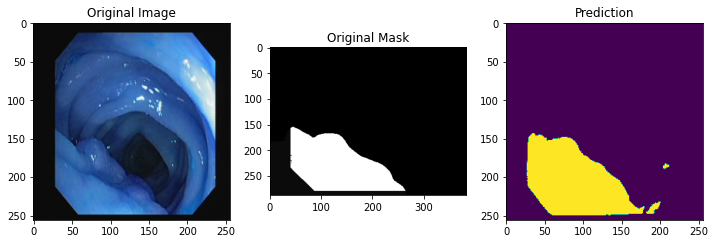

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(img))
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(np.squeeze(cv2.imread(original_mask)))
plt.title('Original Mask')
plt.subplot(1,3,3)
plt.imshow(np.squeeze(pred) > .5)
plt.title('Prediction')
plt.show()